<a href="https://colab.research.google.com/github/sonichandni/Song-Recommendations/blob/master/Song_recommendations_with_Singer_Artists.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('songs.csv',  encoding = "ISO-8859-1")
df.head()

,Song-Name,Singer/Artists,Genre,Album/Movie,User-Rating
1,Aankh Marey,"Kumar Sanu, Mika Singh, Neha Kakkar",BollywoodDance,Simmba,8.8/10
2,Coca Cola,"Neha Kakkar, Tony Kakkar",BollywoodDanceRomantic,Luka Chuppi,9.0/10
3,Apna Time Aayega,Ranveer Singh,BollywoodDance,Gully Boy,9.7/10
4,Mungda,"Jyotica Tangri, Shaan, Subhro Ganguly",BollywoodDance,Total Dhamaal,9.1/10
5,Tere Bin,"Asees Kaur, Rahat Fateh Ali Khan, Tanishk Bagchi",BollywoodRomantic,Simmba,9.2/10


In [4]:
df.shape

(2420, 5)

In [5]:
df.isnull().sum()

Song-Name          0
Singer/Artists    10
Genre              0
Album/Movie        3
User-Rating        0
dtype: int64

In [0]:
df['SongCode'] = ["SB" + str(i) for i in range(df.shape[0])]

In [7]:
df.head()

,Song-Name,Singer/Artists,Genre,Album/Movie,User-Rating,SongCode
1,Aankh Marey,"Kumar Sanu, Mika Singh, Neha Kakkar",BollywoodDance,Simmba,8.8/10,SB0
2,Coca Cola,"Neha Kakkar, Tony Kakkar",BollywoodDanceRomantic,Luka Chuppi,9.0/10,SB1
3,Apna Time Aayega,Ranveer Singh,BollywoodDance,Gully Boy,9.7/10,SB2
4,Mungda,"Jyotica Tangri, Shaan, Subhro Ganguly",BollywoodDance,Total Dhamaal,9.1/10,SB3
5,Tere Bin,"Asees Kaur, Rahat Fateh Ali Khan, Tanishk Bagchi",BollywoodRomantic,Simmba,9.2/10,SB4


In [8]:
songs = df["Singer/Artists"].unique().tolist()
len(songs)

1215

In [0]:
# shuffle song ID's
random.shuffle(songs)

# extract 90% of song ID's
song_train = [songs[i] for i in range(round(0.9*len(songs)))]

# split data into train and validation set
train_df = df[df['Singer/Artists'].isin(song_train)]
validation_df = df[~df['Singer/Artists'].isin(song_train)]

In [10]:
# list to capture the Singer/Artists
like_train = []

# populate the list with the product codes
for i in tqdm(song_train):
    temp = train_df[train_df["Singer/Artists"] == i]["SongCode"].tolist()
    like_train.append(temp)

100%|██████████| 1094/1094 [00:00<00:00, 1414.58it/s]


In [11]:
# list to capture the Singer/Artists
like_val = []

# populate the list with the song codes
for i in tqdm(validation_df['Singer/Artists'].unique()):
    temp = validation_df[validation_df["Singer/Artists"] == i]["SongCode"].tolist()
    like_val.append(temp)

100%|██████████| 121/121 [00:00<00:00, 1408.68it/s]


In [0]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14, min_count=1)

model.build_vocab(like_train, progress_per=200)

In [13]:
model.train(like_train, total_examples = model.corpus_count, 
            epochs=1, report_delay=1)

(2124, 2124)

In [0]:
model.init_sims(replace=True)

In [15]:
print(model)

Word2Vec(vocab=2124, size=100, alpha=0.03)


In [16]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(2124, 100)

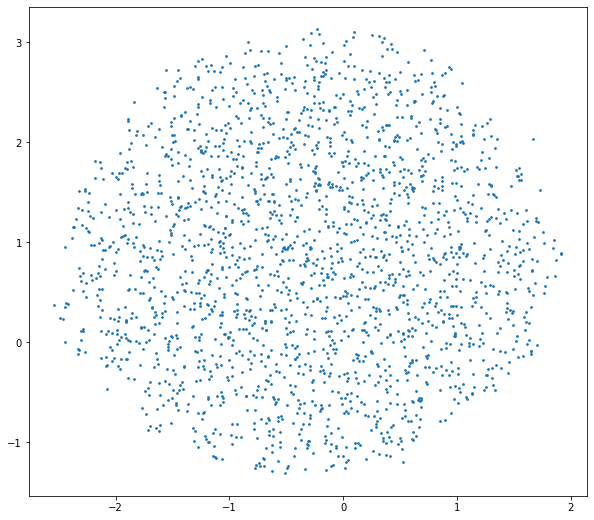

In [17]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [28]:
sng = train_df[["SongCode", "Song-Name"]]
# sng
# remove duplicates
sng.drop_duplicates(inplace=True, subset='SongCode', keep="last")

# # create product-ID and Song-Name dictionary
sng_dict = sng.groupby('SongCode')['Song-Name'].apply(list).to_dict()
sng_dict

{'SB0': ['Aankh Marey'],
 'SB1': ['Coca Cola'],
 'SB10': ['Swag Se Swagat'],
 'SB100': ['Prem Ratan Dhan Payo'],
 'SB1000': ['Sajna Mein Teri Tu Mera'],
 'SB1001': ['Zindagi Do Pal Ki'],
 'SB1002': ['Tauba Yeh Matwali Chaal'],
 'SB1003': ['Main Hoon Hero Tera'],
 'SB1004': ['Daata Tu'],
 'SB1005': ['Ye Dosti Hum Nahi Todenge'],
 'SB1006': ['Saathiya Nahi Jaana'],
 'SB1007': ['Ishq Hua'],
 'SB1009': ['Dil Se Re'],
 'SB1011': ['Meer-E-Kaarwan'],
 'SB1012': ['Ratta Maar'],
 'SB1014': ['Maa Da Laadla'],
 'SB1016': ['Jhanjariya Meri Chanak'],
 'SB1017': ['Pareshaan'],
 'SB1018': ['Paisa Paisa'],
 'SB1019': ['Mere Haath Mein'],
 'SB102': ['Nainowale Ne'],
 'SB1020': ['Do Lafzon Ki Hai Dil Ki Kahani'],
 'SB1021': ['Ishq Sufiyana (Male)'],
 'SB1022': ['Hum Hain Insaaf'],
 'SB1023': ['Meri Maa'],
 'SB1024': ['Zindagi Tujhse Kya Karen Shikvey'],
 'SB1025': ['Dance Pe Chance'],
 'SB1026': ['Tu Hi Hai'],
 'SB1028': ['Love Me Love Me'],
 'SB1029': ['Saajna'],
 'SB103': ['Mummy Kasam'],
 'SB1031': [

In [29]:
# test the dictionary
sng_dict['SB1021']

['Ishq Sufiyana (Male)']

In [0]:
def similar_songs(v, n = 6):
    
    # extract most similar song for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar song
    new_ms = []
    for j in ms:
        pair = (sng_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms    

In [31]:
similar_songs(model['SB1021'])

[('Tera Hone Laga Hoon', 0.2961791455745697),
 ('Saiyaara', 0.2876753509044647),
 ('Jatt Jaguar', 0.28458499908447266),
 ('Hafiz Hafiz', 0.28405067324638367),
 ('Hoor', 0.2758209705352783),
 ('Paayal Meri', 0.26008737087249756)]